In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import sys
import warnings
from collections import Counter
from IPython.display import Image, Audio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
import music21
from music21 import *
import os
import glob

# Set random seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [ ]:
filepath = "/content/Music/"
all_midis = []

for file_path in glob.glob(filepath + "*.mid"):
    midi = converter.parse(file_path)
    all_midis.append(midi)

In [ ]:
def get_notes_from_midi(midi):
    notes = []

    for element in midi.flat:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

# Getting the list of notes as Corpus
Corpus = [note for midi in all_midis for note in get_notes_from_midi(midi)]
print("Total notes in all the midis in the dataset:", len(Corpus))


Total notes in all the midis in the dataset: 137114


In [ ]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['E5', 'E-5', 'E5', 'E-5', 'E5', 'B4', 'D5', 'C5', 'A4', 'A2', 'E3', 'A3', 'C4', 'E4', 'A4', 'B4', 'E2', 'E3', 'G#3', 'E4', 'G#4', 'B4', 'C5', 'A2', 'E3', 'A3', 'E4', 'E5', 'E-5', 'E5', 'E-5', 'E5', 'B4', 'D5', 'C5', 'A4', 'A2', 'E3', 'A3', 'C4', 'E4', 'A4', 'B4', 'E2', 'E3', 'G#3', 'E4', 'C5', 'B4', 'A4']


In [ ]:
!apt-get install -y lilypond

In [ ]:
from music21 import environment
environment.set('lilypondPath', '/usr/bin/lilypond')

In [ ]:
print(Corpus)

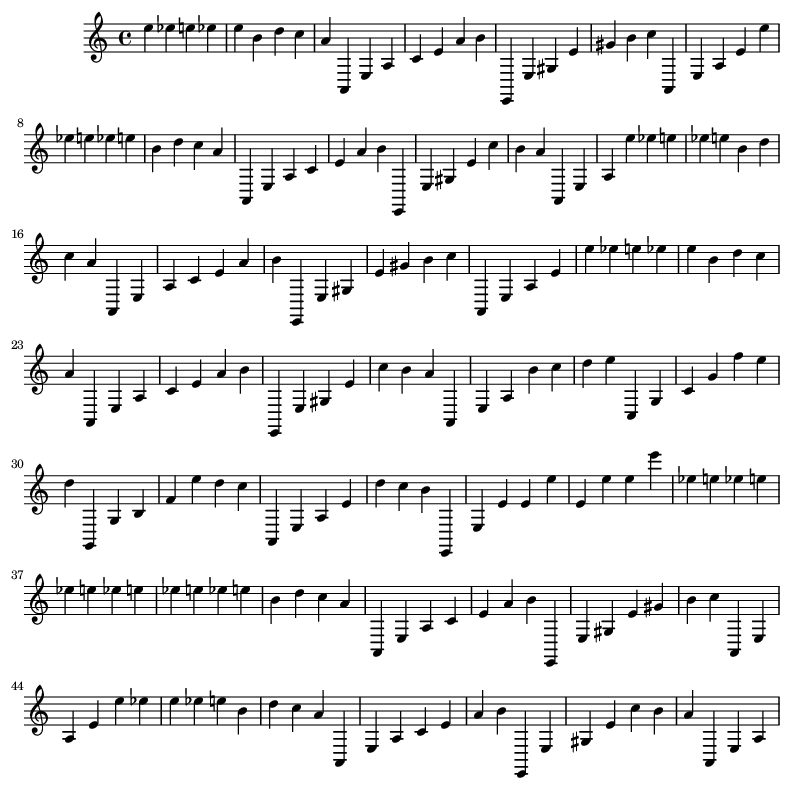

In [ ]:
def show(music):
    display(Image(str(music.write("lily.png"))))

def create_chords_and_notes(snippet):
    melody = stream.Stream()
    offset = 0

    for item in snippet:
        if is_chord(item):
            chord_snip = create_chord(item)
            chord_snip.offset = offset
            melody.append(chord_snip)
        else:
            note_snip = create_note_from_str(item)
            note_snip.offset = offset
            melody.append(note_snip)

        offset += 1

    return melody


def is_chord(item):
    return "." in item or item.isdigit()


def create_chord(chord_notes_str):
    chord_notes = [note.Note(int(note_str)) for note_str in chord_notes_str.split(".")]
    return chord.Chord(chord_notes)


def create_note_from_str(note_str):
    return note.Note(note_str)

Melody_Snippet = create_chords_and_notes(Corpus[:200])
show(Melody_Snippet)



In [ ]:
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 368


In [ ]:
notes = list(count_num.keys())
recurrence = list(count_num.values())

average_recurrence = sum(recurrence) / len(recurrence)
max_recurrence = max(recurrence)
min_recurrence = min(recurrence)

print("Average recurrence for a note in Corpus:", average_recurrence)
print("Most frequent note in Corpus appeared:", max_recurrence, "times")
print("Least frequent note in Corpus appeared:", min_recurrence, "time")


Average recurrence for a note in Corpus: 372.5923913043478
Most frequent note in Corpus appeared: 4205 times
Least frequent note in Corpus appeared: 1 time


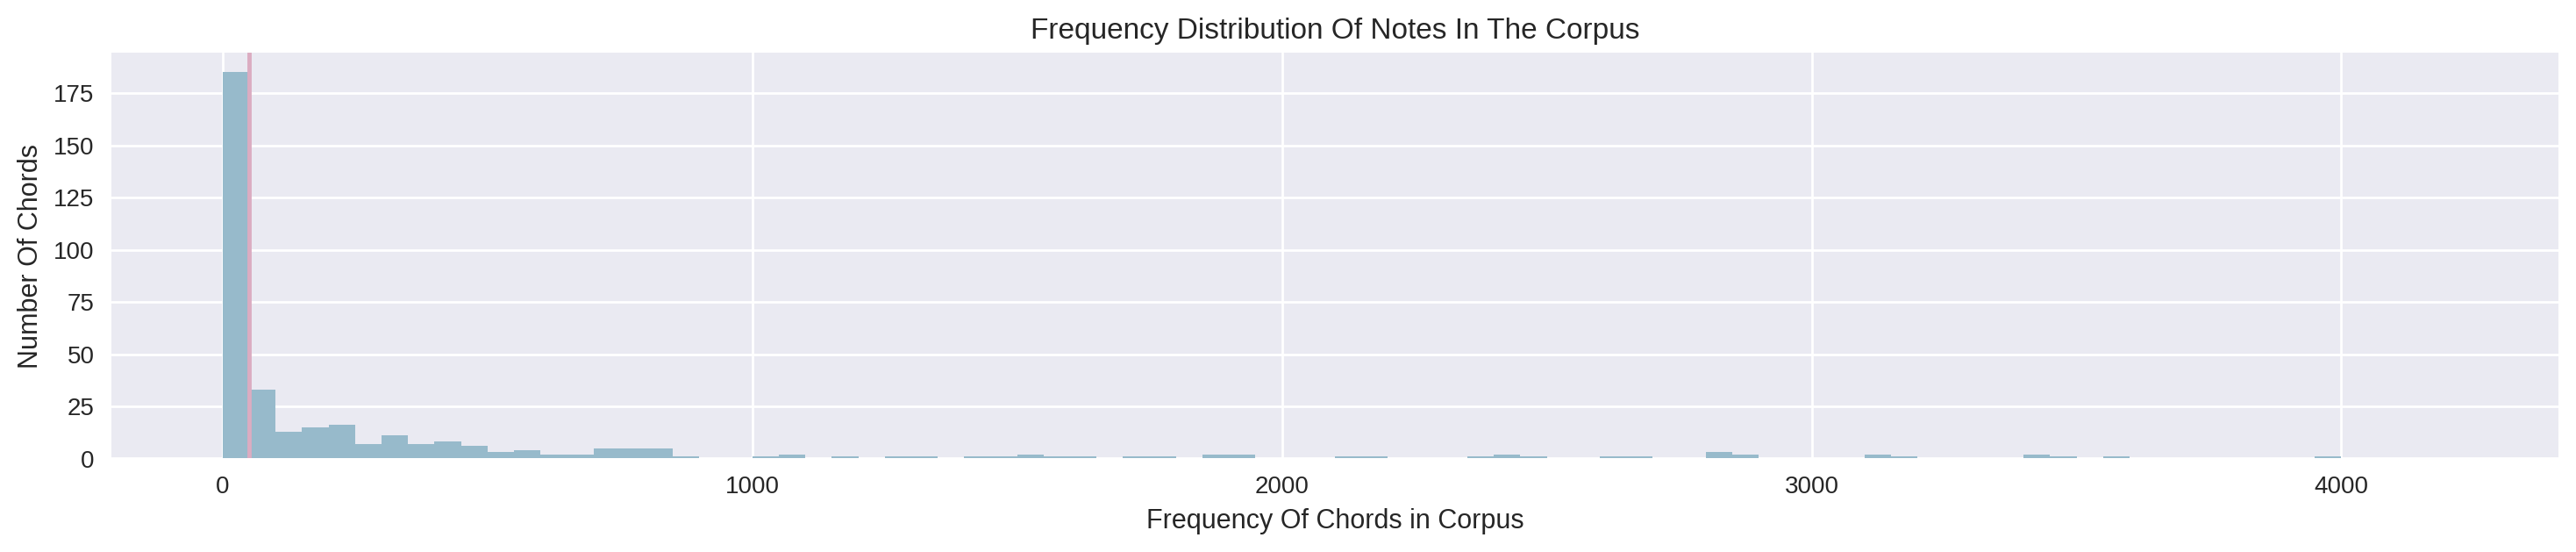

In [ ]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(18, 3))
    plt.hist(recurrence, bins=np.arange(0, max(recurrence), 50), color="#97BACB")
    plt.axvline(x=50, color="#DBACC1")
    plt.title("Frequency Distribution Of Notes In The Corpus")
    plt.xlabel("Frequency Of Chords in Corpus")
    plt.ylabel("Number Of Chords")
    plt.show()


In [ ]:
rare_notes = [key for key, value in count_num.items() if value < 50]
print("Total number of notes that occur less than 50 times:", len(rare_notes))

Total number of notes that occur less than 50 times: 185


In [ ]:
Corpus = [element for element in Corpus if element not in rare_notes]
print("Length of Corpus after eliminating the rare notes:", len(Corpus))

Length of Corpus after eliminating the rare notes: 135537


In [ ]:
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus)  # Length of corpus
L_symb = len(symb)  # Length of total unique characters

# Building dictionary to access the vocabulary from indices and vice versa
mapping = {c: i for i, c in enumerate(symb)}
reverse_mapping = {i: c for i, c in enumerate(symb)}

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)


Total number of characters: 135537
Number of unique characters: 183


In [ ]:
length = 40
features = [[mapping[j] for j in Corpus[i:i + length]] for i in range(L_corpus - length)]
targets = [mapping[Corpus[i + length]] for i in range(L_corpus - length)]

L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 135497


In [ ]:
# reshape X and normalize
X = np.array(features).reshape(L_datapoints, length, 1) / float(L_symb)
# one hot encode the output variable
y = tf.keras.utils.to_categorical(targets)

In [ ]:
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()

model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(256, return_sequences=True))  # Return sequences for better information flow
model.add(Dropout(0.1))

model.add(LSTM(256))
model.add(Dropout(0.1))

model.add(Dense(256))
model.add(Dropout(0.1))

model.add(Dense(y.shape[1], activation='softmax'))

# Compiling the model for training
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 dropout_8 (Dropout)         (None, 40, 512)           0         
                                                                 
 lstm_7 (LSTM)               (None, 40, 256)           787456    
                                                                 
 dropout_9 (Dropout)         (None, 40, 256)           0         
                                                                 
 lstm_8 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)              

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200
424/424 [==============================] - 30s 59ms/step - loss: 4.5117
Epoch 2/200
424/424 [==============================] - 25s 60ms/step - loss: 4.4509
Epoch 3/200
424/424 [==============================] - 25s 58ms/step - loss: 4.4213
Epoch 4/200
424/424 [==============================] - 25s 59ms/step - loss: 4.3814
Epoch 5/200
424/424 [==============================] - 25s 59ms/step - loss: 4.3354
Epoch 6/200
424/424 [==============================] - 25s 59ms/step - loss: 4.2639
Epoch 7/200
424/424 [==============================] - 25s 59ms/step - loss: 4.1592
Epoch 8/200
424/424 [==============================] - 25s 59ms/step - loss: 4.0107
Epoch 9/200
424/424 [==============================] - 25s 58ms/step - loss: 3.8435
Epoch 10/200
424/424 [==============================] - 25s 59ms/step - loss: 3.6657
Epoch 11/200
424/424 [==============================] - 25s 59ms/step - loss: 3.4916
Epoch 12/200
424/424 [==============================] - 25s 59ms/step - lo

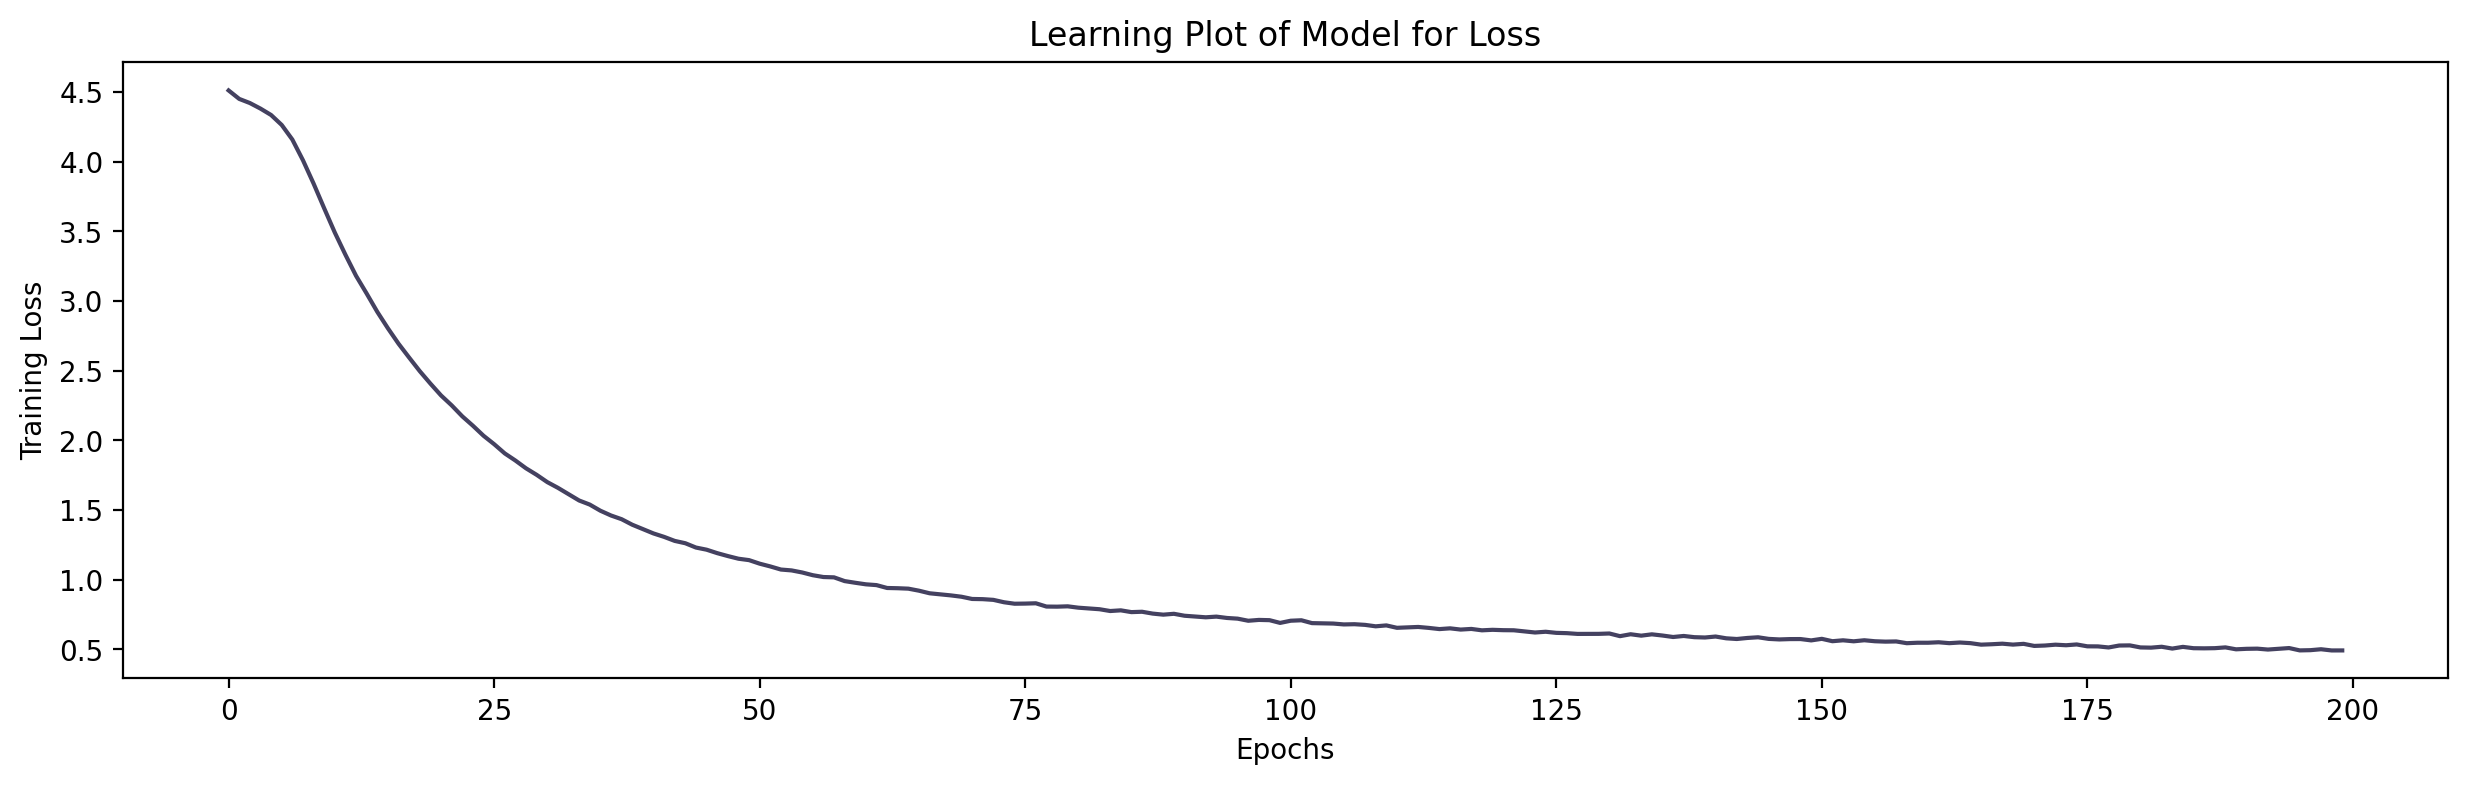

In [ ]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(15, 4))
plt.title("Learning Plot of Model for Loss")
plt.plot(history_df["loss"], color="#444160")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

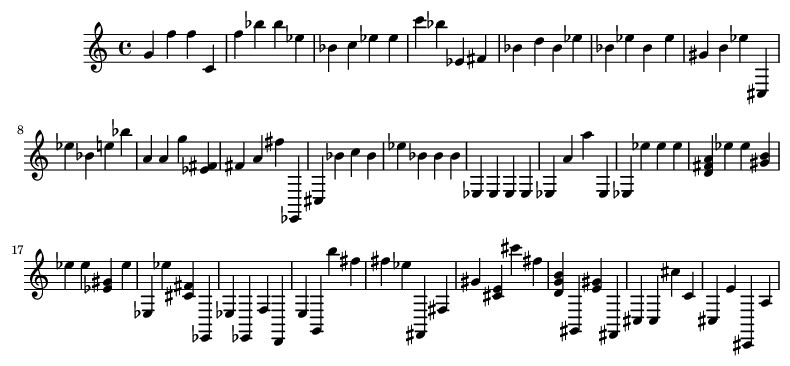

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = create_chords_and_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)
show(Melody)
from google.colab import files
Melody.write('midi', fp='/content/melody.mid')
files.download('/content/melody.mid')

